In [220]:
%load_ext autoreload
%autoreload 2

import terra
import numpy as np
import meerkat as mk
import pandas as pd
import torch

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, FastICA
import meerkat.contrib.mimic
from domino.evaluate.linear import induce_correlation
from domino.evaluate.train import train_linear_slices, train_model


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [221]:
partial(torch.mean(dp["activation_layer4"], axis=[-1, -2])

,(TensorColumn)
0,torch.Tensor(shape=torch.Size([2048]))
1,torch.Tensor(shape=torch.Size([2048]))
2,torch.Tensor(shape=torch.Size([2048]))
3,torch.Tensor(shape=torch.Size([2048]))
4,torch.Tensor(shape=torch.Size([2048]))
...,...
5357,torch.Tensor(shape=torch.Size([2048]))
5358,torch.Tensor(shape=torch.Size([2048]))
5359,torch.Tensor(shape=torch.Size([2048]))
5360,torch.Tensor(shape=torch.Size([2048]))


In [201]:
models_df = train_linear_slices.out(1302).load()
inp = train_linear_slices.inp(1302)
models_df.iloc[10:]

,target,correlate,corr,num_examples,run_id
10,Pleural_Effusion_uzeros,gender_male,0.2,30000.0,1314
11,Pleural_Effusion_uzeros,gender_male,0.3,30000.0,1315
12,Pleural_Effusion_uzeros,gender_male,0.4,30000.0,1316
13,Pleural_Effusion_uzeros,gender_male,0.5,30000.0,1317
14,Pleural_Effusion_uzeros,gender_male,0.6,30000.0,1318
...,...,...,...,...,...
98,Support_Devices_uzeros,young,0.4,30000.0,1452
99,Support_Devices_uzeros,young,0.5,30000.0,1453
100,Support_Devices_uzeros,young,0.6,30000.0,1454
101,Support_Devices_uzeros,young,0.7,30000.0,1455


In [209]:
# load training 
run_id = 1314
inp = train_model.inp(run_id)
dp = inp["dp"].load()
target, correlate = inp["target_correlate"]
corr = inp["corr"]
model = train_model.get_artifacts(group_name="best_chkpt", run_id=run_id)["model"].load()

In [199]:
from scipy.stats import pearsonr
indices = induce_correlation(
    dp, corr=corr, n=30000, attr_a=target, attr_b=correlate, match_mu=True
)
new_dp = dp.lz[indices]
split_mask = new_dp["split"].data == "train"
new_dp = new_dp.lz[split_mask]
pearsonr(new_dp[target], new_dp[correlate])

(0.7010561490839832, 0.0)

In [210]:
from domino.vision import score
model = train_model.get_artifacts(group_name="best_chkpt", run_id=run_id)["model"].load()

dp = score(
    model,
    dp=dp.lz[(dp["split"].data == "validate") | (dp["split"].data == "test")],
    input_column="input_224",
    id_column="dicom_id",
    target_column=target,
    layers={"layer4": model.model.layer4},
    batch_size=512
)

100%|██████████| 11/11 [00:39<00:00,  3.55s/it]


In [211]:
roc_auc_score(dp[correlate], dp["output"].data[:, -1])

0.5471191153078503

In [213]:
def fit_probe(dp, model):
    print("Fitting...")
    valid_dp = dp.lz[dp["split"].data == "validate"]
    acts = valid_dp["activation_layer4"].mean(dim=[-1, -2])
    model.fit(acts, valid_dp[correlate])

    print("Predicting...")
    test_dp = dp.lz[dp["split"].data == "test"]
    acts = test_dp["activation_layer4"].mean(dim=[-1, -2])
    test_dp["pred"] = model.predict_proba(acts)
    return test_dp, model

Fitting...
Predicting...
0.8812217533773912


<BarContainer object of 2048 artists>

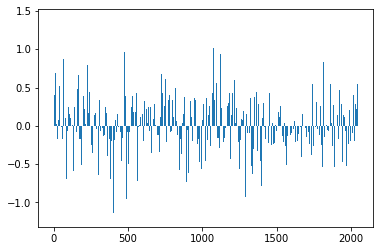

In [214]:
out_dp, model = fit_probe(dp, LogisticRegression())
print(roc_auc_score(out_dp[correlate], out_dp["pred"].data[:, 1]))
plt.bar(x=np.arange(len(model.coef_[0])), height=model.coef_[0])

In [215]:
def fit_pca_probe(dp, model_cls, **kwargs):
    print("Fitting...")
    valid_dp = dp.lz[dp["split"].data == "validate"]
    model = model_cls(**kwargs)
    acts = valid_dp["activation_layer4"].mean(dim=[-1, -2])
    pca = PCA().fit(acts)
    components = pca.transform(acts)
    model.fit(components, valid_dp[correlate])

    print("Predicting...")
    test_dp = dp.lz[dp["split"].data == "test"]
    acts = test_dp["activation_layer4"].mean(dim=[-1, -2])
    components = pca.transform(acts)
    test_dp["components"] = components
    test_dp["pred"] = model.predict_proba(components)
    return test_dp, model, pca 

Fitting...
Predicting...
0.8823493519272033


<BarContainer object of 1959 artists>

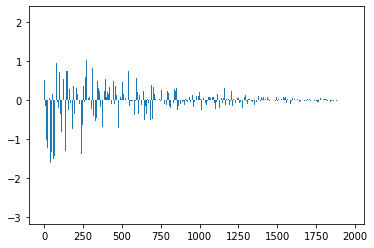

In [216]:
out_dp, model, pca = fit_pca_probe(dp, LogisticRegression)
print(roc_auc_score(out_dp[correlate], out_dp["pred"].data[:, 1]))
plt.bar(x=np.arange(len(model.coef_[0])), height=model.coef_[0])

In [139]:
np.argsort(-np.abs(model.coef_))[0, :10]

array([ 31,  12,  16, 127,  30,  25,  46,  49, 108,  90])

In [151]:
roc_auc_score(out_dp[correlate], out_dp["components"].data[:, 108])

0.47420121462656406

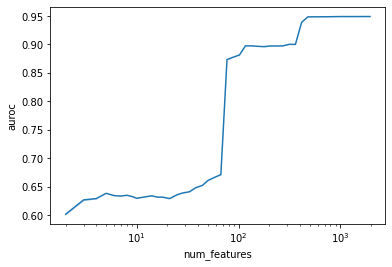

In [183]:
def plot_features_v_auroc(model, dp):
    results = []
    for num_features in np.logspace(1, np.log2(len(model.coef_[0])), num=50, base=2):
        num_features = int(num_features)
        mask = np.argsort(-np.abs(model.coef_))[0, :num_features]
        preds = np.matmul(dp["components"].data[:, mask], model.coef_.T[mask, :])
        score = roc_auc_score(dp[correlate], preds)
        results.append({"auroc": score, "num_features": num_features})
    plot_df = pd.DataFrame(results)
    sns.lineplot(data=plot_df, x="num_features", y="auroc")
    plt.xscale("log")
    return plot_df
plot_features_v_auroc(model, out_dp);

In [185]:
scores = []
for comp_idx in range(out_dp["components"].data.shape[-1]):
    scores.append(
        roc_auc_score(out_dp[correlate], out_dp["components"].data[:, comp_idx])
    )
np.sort(scores)

array([0.24111467, 0.28825554, 0.408827  , ..., 0.59450454, 0.6221593 ,
       0.68337911])

In [169]:
model.coef_[0]

array([-2.09033461e-01,  1.97195405e-01, -7.63946056e-01, ...,
        3.14069287e-03,  3.09260859e-03,  4.65726965e-15])

In [225]:
from functools import partial
partial(torch.mean, dim=[-1, -2]).func.__name__

'mean'